# Tutorial 1: "What" models

**Week 1, Day 1: Model Types**

**By Neuromatch Academy**

__Content creators:__ Matt Laporte, Byron Galbraith, Konrad Kording

__Content reviewers:__ Dalin Guo, Aishwarya Balwani, Madineh Sarvestani, Maryam Vaziri-Pashkam, Michael Waskom, Ella Batty

__Production editors:__ Gagana B, Spiros Chavlis

<br>

We would like to acknowledge [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x) for sharing their data, a subset of which is used here.

___
# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

This is tutorial 1 of a 3-part series on different flavors of models used to understand neural data. In this tutorial we will explore 'What' models, used to describe the data. To understand what our data looks like, we will visualize it in different ways. Then we will compare it to simple mathematical models. Specifically, we will:

- Load a dataset with spiking activity from hundreds of neurons and understand how it is organized
- Make plots to visualize characteristics of the spiking activity across the population
- Compute the distribution of "inter-spike intervals" (ISIs) for a single neuron
- Consider several formal models of this distribution's shape and fit them to the data "by hand"



# Tutorial reflection

* This tutorial was a brief overview of descriptive modeling in computational neuroscience. We used numpy library to manipulate data and matplotlib for plotting - in particular hist and event_plot function. A new type of plot that I learned in this tutorial: 'Raster Plot'.

* Key concepts learned: For a given extracellular recording, most neurons are relatively quiet compared to the mean/median neuron in the population since they don't fire as often. Similarly, the inter-spike interval (ISI) follows a reverse exponential distribution - meaning that most spikes happen back-to-back and very few have longer intervals.

* I have added my own comprehension notes next to a ⏰ emoji and coding notes with a # comments within code-block.

Python requires you to explicitly "import" libraries before their functions are available to use. We will always specify our imports at the beginning of each notebook or script.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Tutorial notebooks typically begin with several set-up steps that are hidden from view by default.

**Important:** Even though the code is hidden, you still need to run it so that the rest of the notebook can work properly. Step through each cell, either by pressing the play button in the upper-left-hand corner or with a keyboard shortcut (`Cmd-Return` on a Mac, `Ctrl-Enter` otherwise). A number will appear inside the brackets (e.g. `[3]`) to tell you that the cell was executed and what order that happened in.

If you are curious to see what is going on inside each cell, you can double click to expand. Once expanded, double-click the white space to the right of the editor to collapse again.

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [4]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

---
# "What" models

---

# Section 1: Exploring the Steinmetz dataset

In this tutorial we will explore the structure of a neuroscience dataset.

We consider a subset of data from a study of [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode's measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to `spike_times` in the preceding setup.

Typically a dataset comes with some information about its structure. However, this information may be incomplete. You might also apply some transformations or "pre-processing" to create a working representation of the data of interest, which might go partly undocumented depending on the circumstances. In any case it is important to be able to use the available tools to investigate unfamiliar aspects of a data structure.

Let's see what our data looks like...

## Section 1.1: Warming up with `spike_times`

What is the Python type of our variable?

In [5]:
type(spike_times)

numpy.ndarray

You should see `numpy.ndarray`, which means that it's a normal NumPy array.

If you see an error message, it probably means that you did not execute the set-up cells at the top of the notebook. So go ahead and make sure to do that.

Once everything is running properly, we can ask the next question about the dataset: what's its shape?

In [6]:
spike_times.shape

(734,)

There are 734 entries in one dimension, and no other dimensions. What is the Python type of the first entry, and what is *its* shape?

In [7]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


It's also a NumPy array with a 1D shape! Why didn't this show up as a second dimension in the shape of `spike_times`? That is, why not `spike_times.shape == (734, 826)`?

To investigate, let's check another entry.

In [8]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


It's also a 1D NumPy array, but it has a different shape. Checking the NumPy types of the values in these arrays, and their first few elements, we see they are composed of floating point numbers (not another level of `np.ndarray`):

In [9]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Note that this time we've checked the NumPy `dtype` rather than the Python variable type. These two arrays contain floating point numbers ("floats") with 32 bits of precision.

The basic picture is coming together:
- `spike_times` is 1D, its entries are NumPy arrays, and its length is the number of neurons (734): by indexing it, we select a subset of neurons.
- An array in `spike_times` is also 1D and corresponds to a single neuron; its entries are floating point numbers, and its length is the number of spikes attributed to that neuron. By indexing it, we select a subset of spike times for that neuron.

Visually, you can think of the data structure as looking something like this:

```
| . . . . . |
| . . . . . . . . |
| . . . |
| . . . . . . . |
```

Before moving on, we'll calculate and store the number of neurons in the dataset and the number of spikes per neuron:

In [11]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


## Section 1.2: Getting warmer: counting and plotting total spike counts

As we've seen, the number of spikes over the entire recording is variable between neurons. More generally, some neurons tend to spike more than others in a given period. Let's explore what the distribution of spiking looks like across all the neurons in the dataset.

Are most neurons "loud" or "quiet", compared to the average? To see, we'll define bins of constant width in terms of total spikes and count the neurons that fall in each bin. This is known as a "histogram".

You can plot a histogram with the matplotlib function `plt.hist`. If you just need to compute it, you can use the numpy function `np.histogram` instead.

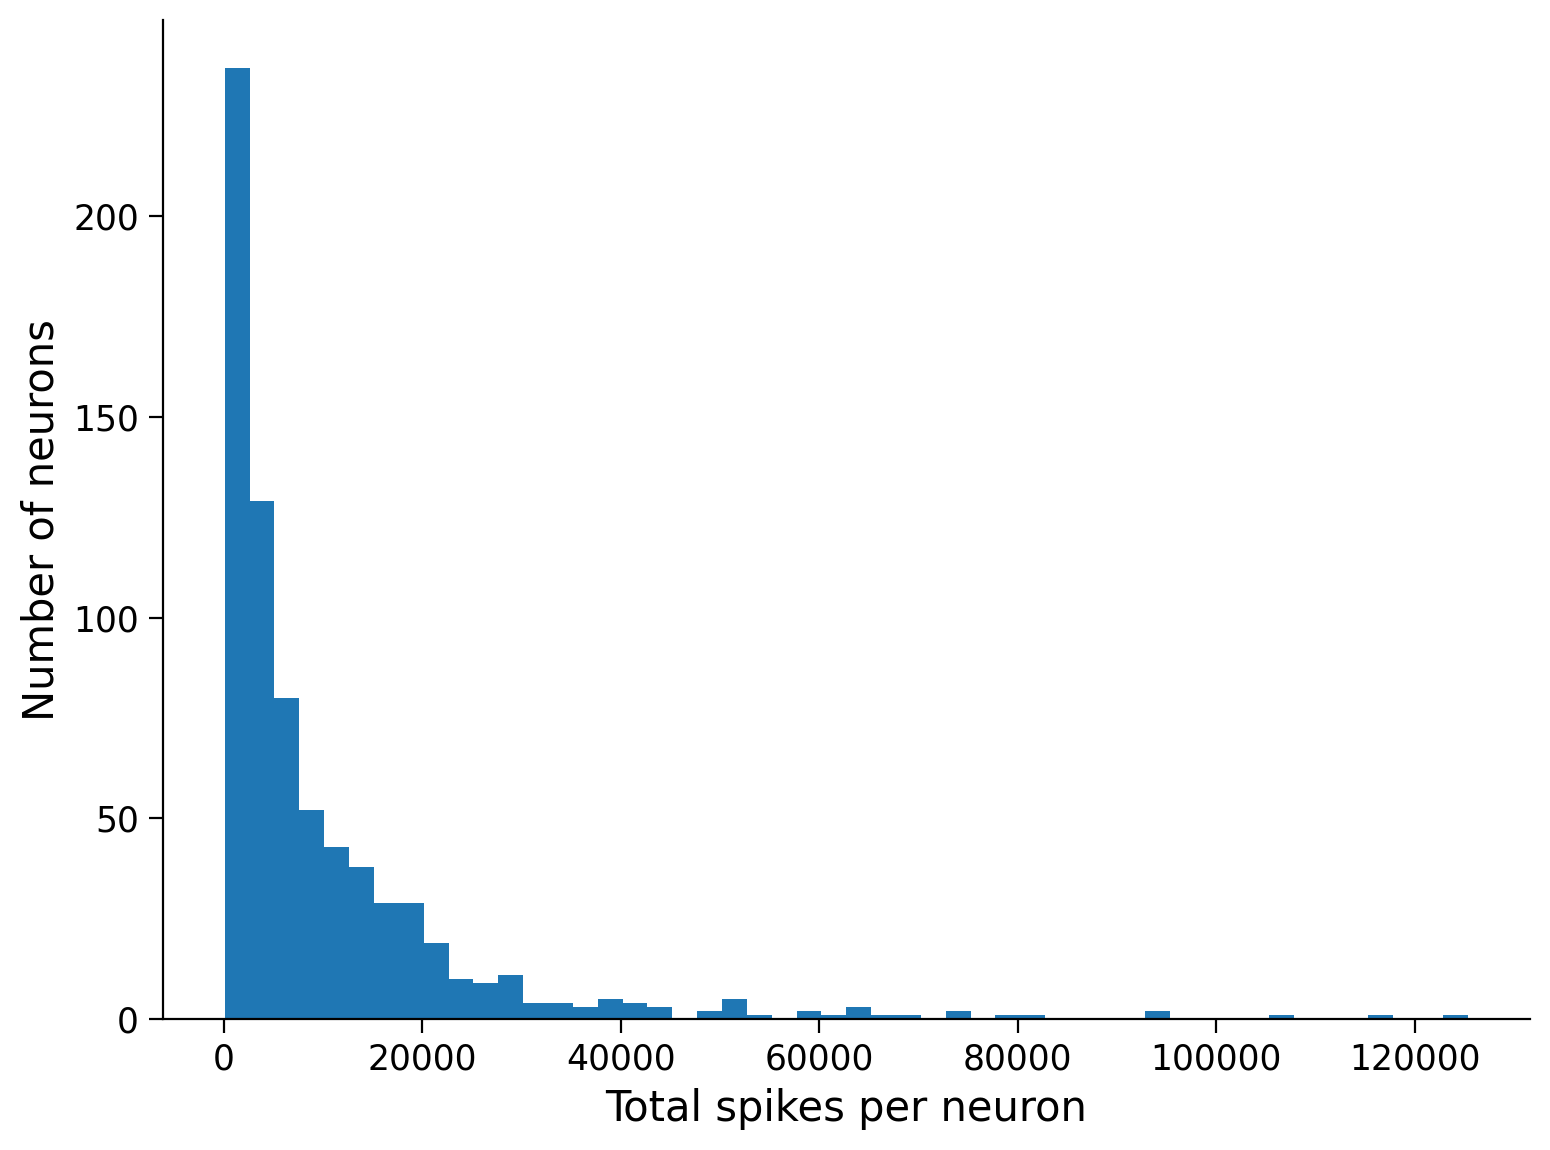

In [12]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

Let's see what percentage of neurons have a below-average spike count:

In [14]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean() #Total_spikes_per_neuron is a LIST, where we evaluated a BOOLEAN and then found the MEAN for values that were TRUE for the boolean.
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


⏰ *The previous line of code suggests that SOME neurons spike a lot whereas MOST neurons have a low number of spikes - this leads to a skewed distribution, as shown in the histogram.*



We can also see this by adding the average spike count to the histogram plot:

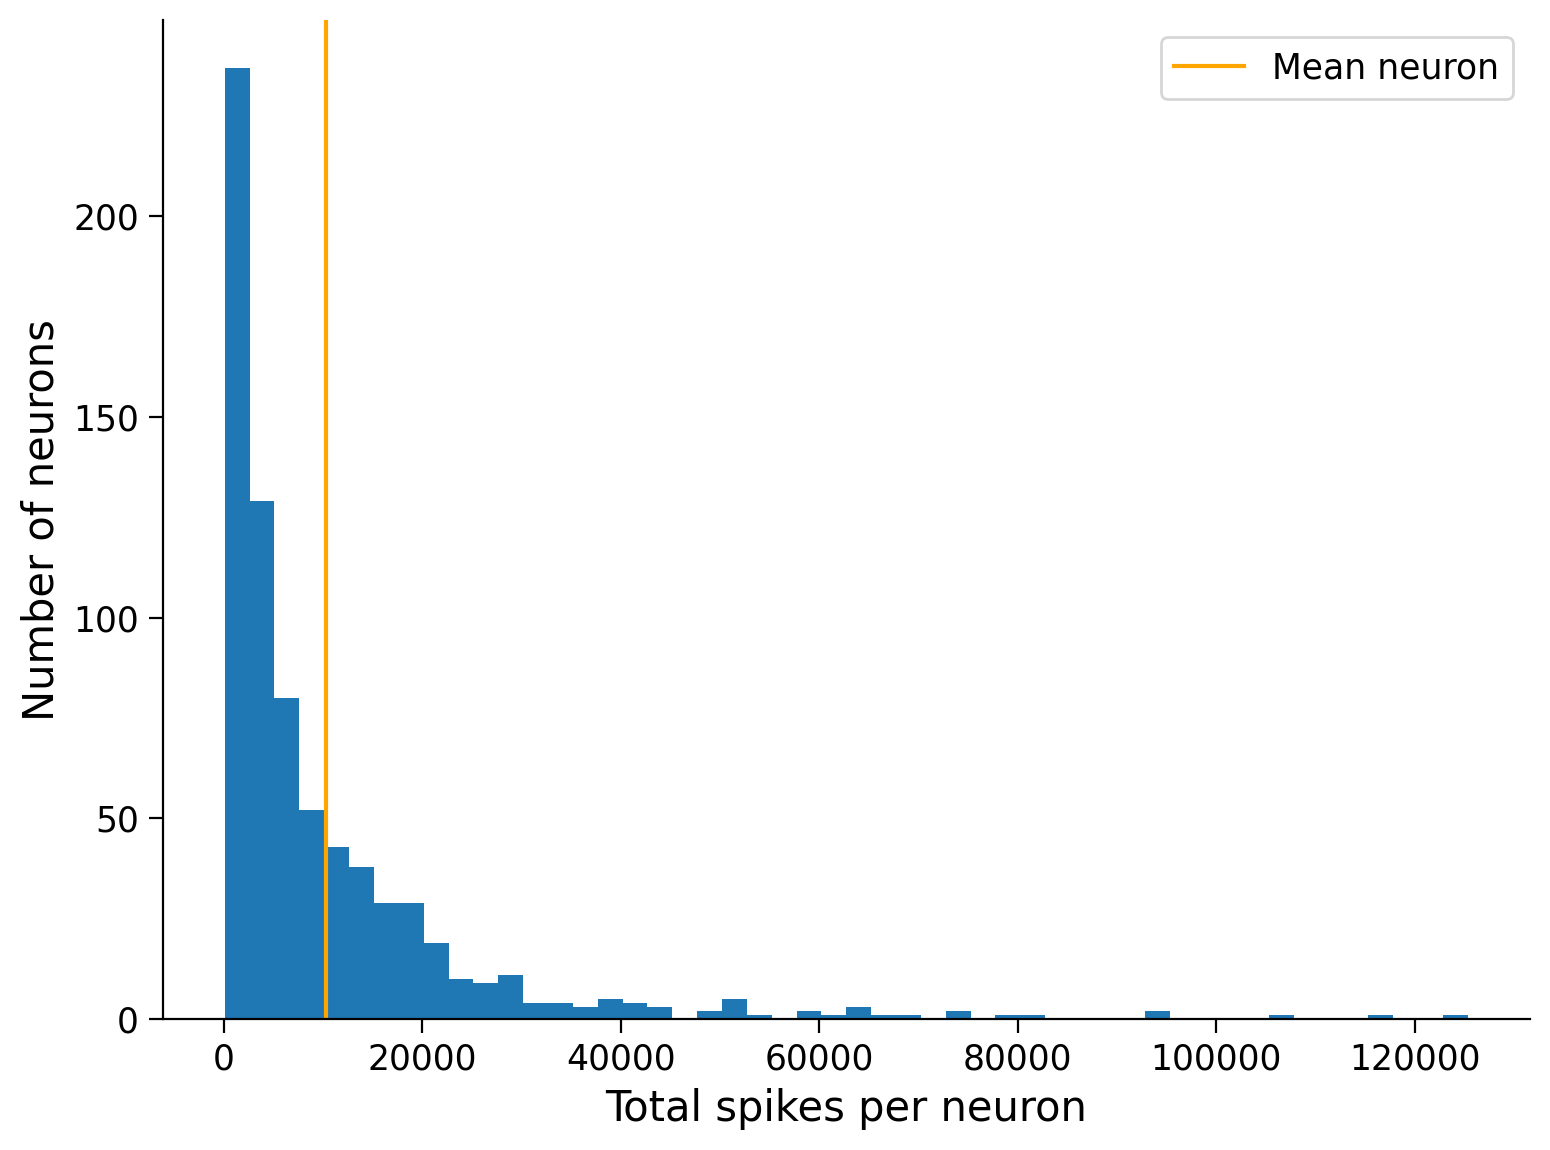

In [23]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

This shows that the majority of neurons are relatively "quiet" compared to the mean, while a small number of neurons are exceptionally "loud": they must have spiked more often to reach a large count.

### Coding Exercise 1.2: Comparing mean and median neurons

If the mean neuron is more active than 68% of the population, what does that imply about the relationship between the mean neuron and the median neuron?

*Exercise objective:* Reproduce the plot above, but add the median neuron.


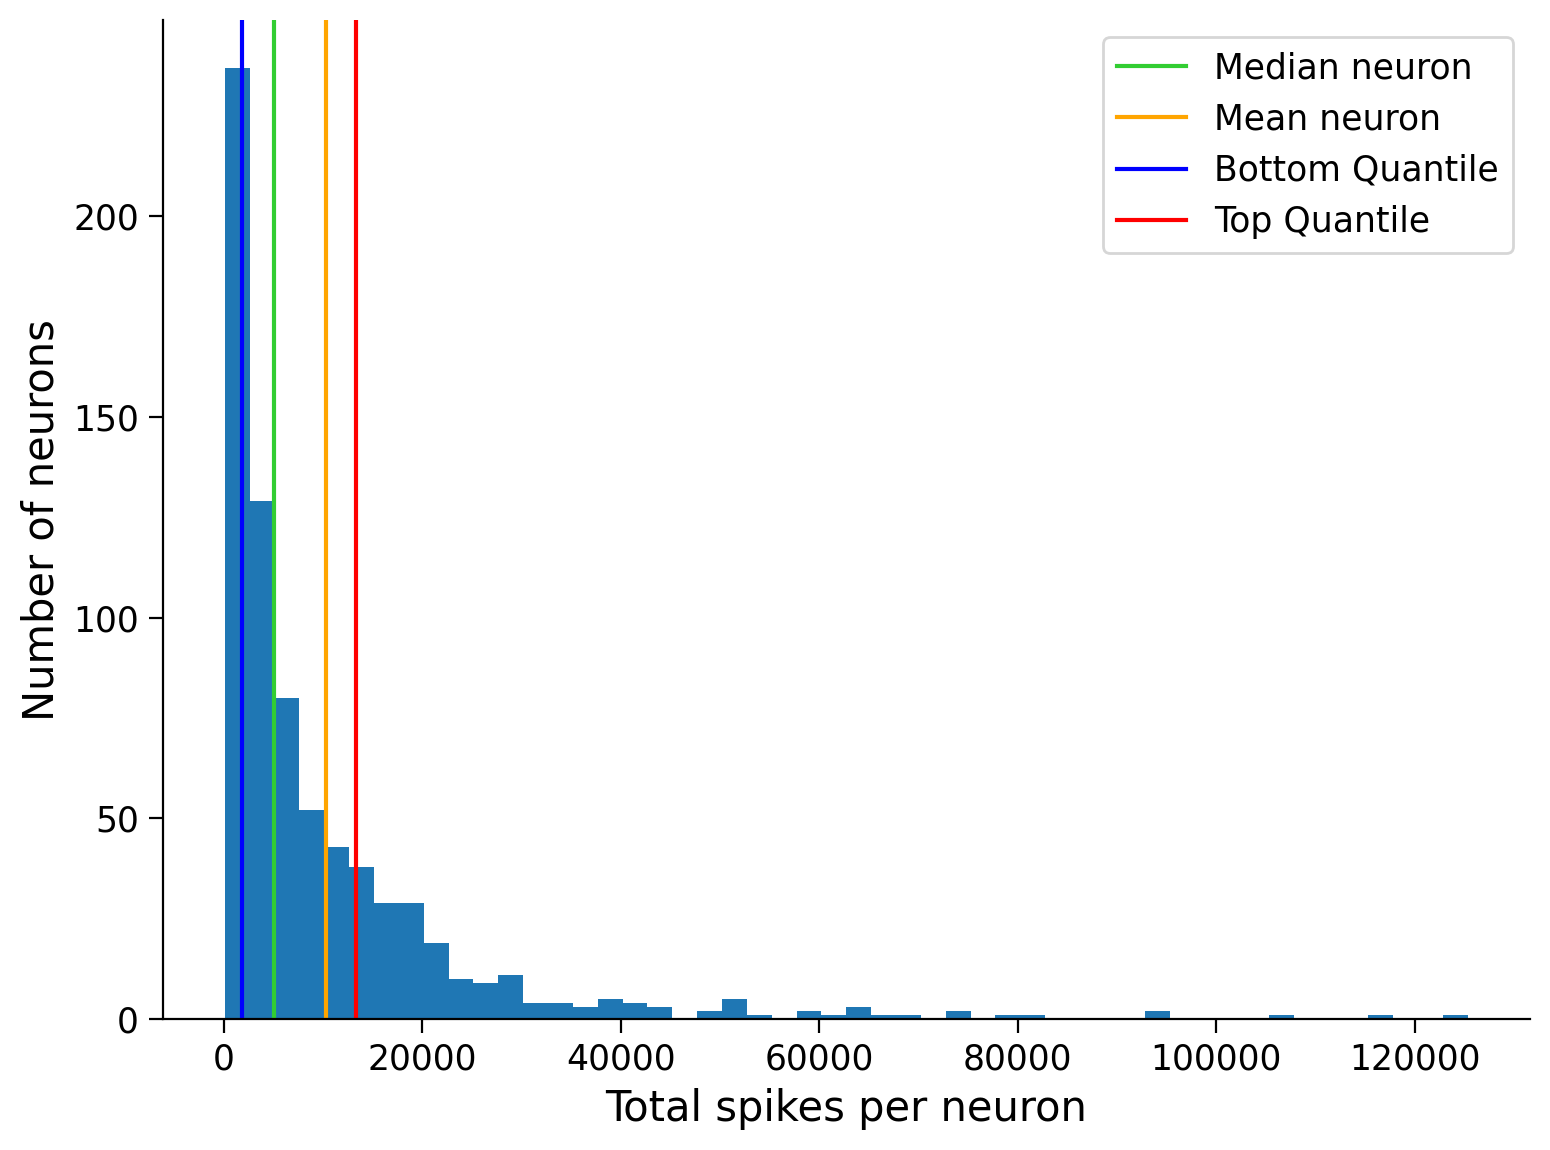

In [16]:
#################################################################################
## TODO for students:
# Fill out function and remove
#raise NotImplementedError("Student exercise: complete histogram plotting with median")
#################################################################################

# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)
bottom_quartile = np.quantile(total_spikes_per_neuron, 0.25)
top_quartile = np.quantile(total_spikes_per_neuron, 0.75)

# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.axvline(bottom_quartile, color="blue", label="Bottom Quantile")
plt.axvline(top_quartile, color="red", label="Top Quantile")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()


*Bonus:* The median is the 50th percentile. What about other percentiles? Can you show the interquartile range on the histogram?

---

# Section 2: Visualizing neuronal spiking activity

*Estimated timing to here from start of tutorial: 15 min*

## Section 2.1: Getting a subset of the data

Now we'll visualize trains of spikes. Because the recordings are long, we will first define a short time interval and restrict the visualization to only the spikes in this interval. We defined a helper function, `restrict_spike_times`, to do this for you. If you call `help()` on the function, it will tell you a little bit about itself:

In [18]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [26]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [20]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

Is this a representative interval? What fraction of the total spikes fall in this interval?

In [21]:
original_counts = sum([len(spikes) for spikes in spike_times]) #Total number of spikes in dataset.
interval_counts = sum([len(spikes) for spikes in interval_spike_times]) #Total number of spikes within the 5-15s interval.
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


How does this compare to the ratio between the interval duration and the experiment duration? (What fraction of the total time is in this interval?)

We can approximate the experiment duration by taking the minimum and maximum spike time in the whole dataset. To do that, we "concatenate" all of the neurons into one array and then use `np.ptp` ("peak-to-peak") to get the difference between the maximum and minimum value:

In [30]:
spike_times_flat = np.concatenate(spike_times) #Puts all the spikes into a singular array. We wouldn't be able to tell which spike came from which neuron in this array.
experiment_duration = np.ptp(spike_times_flat) #last peak - first peak = experiment time
interval_duration = t_interval[1] - t_interval[0] #15-5 = 10s since we already set t_interval = (5,15)

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


In [35]:
#Understand what happened above
print(np.shape(spike_times))
np.shape(spike_times_flat)

(734,)


(7574404,)

These two values—the fraction of total spikes and the fraction of total time—are similar. This suggests the average spike rate of the neuronal population is not very different in this interval compared to the entire recording.

## Section 2.2: Plotting spike trains and rasters

Now that we have a representative subset, we're ready to plot the spikes, using the matplotlib `plt.eventplot` function. Let's look at a single neuron first:

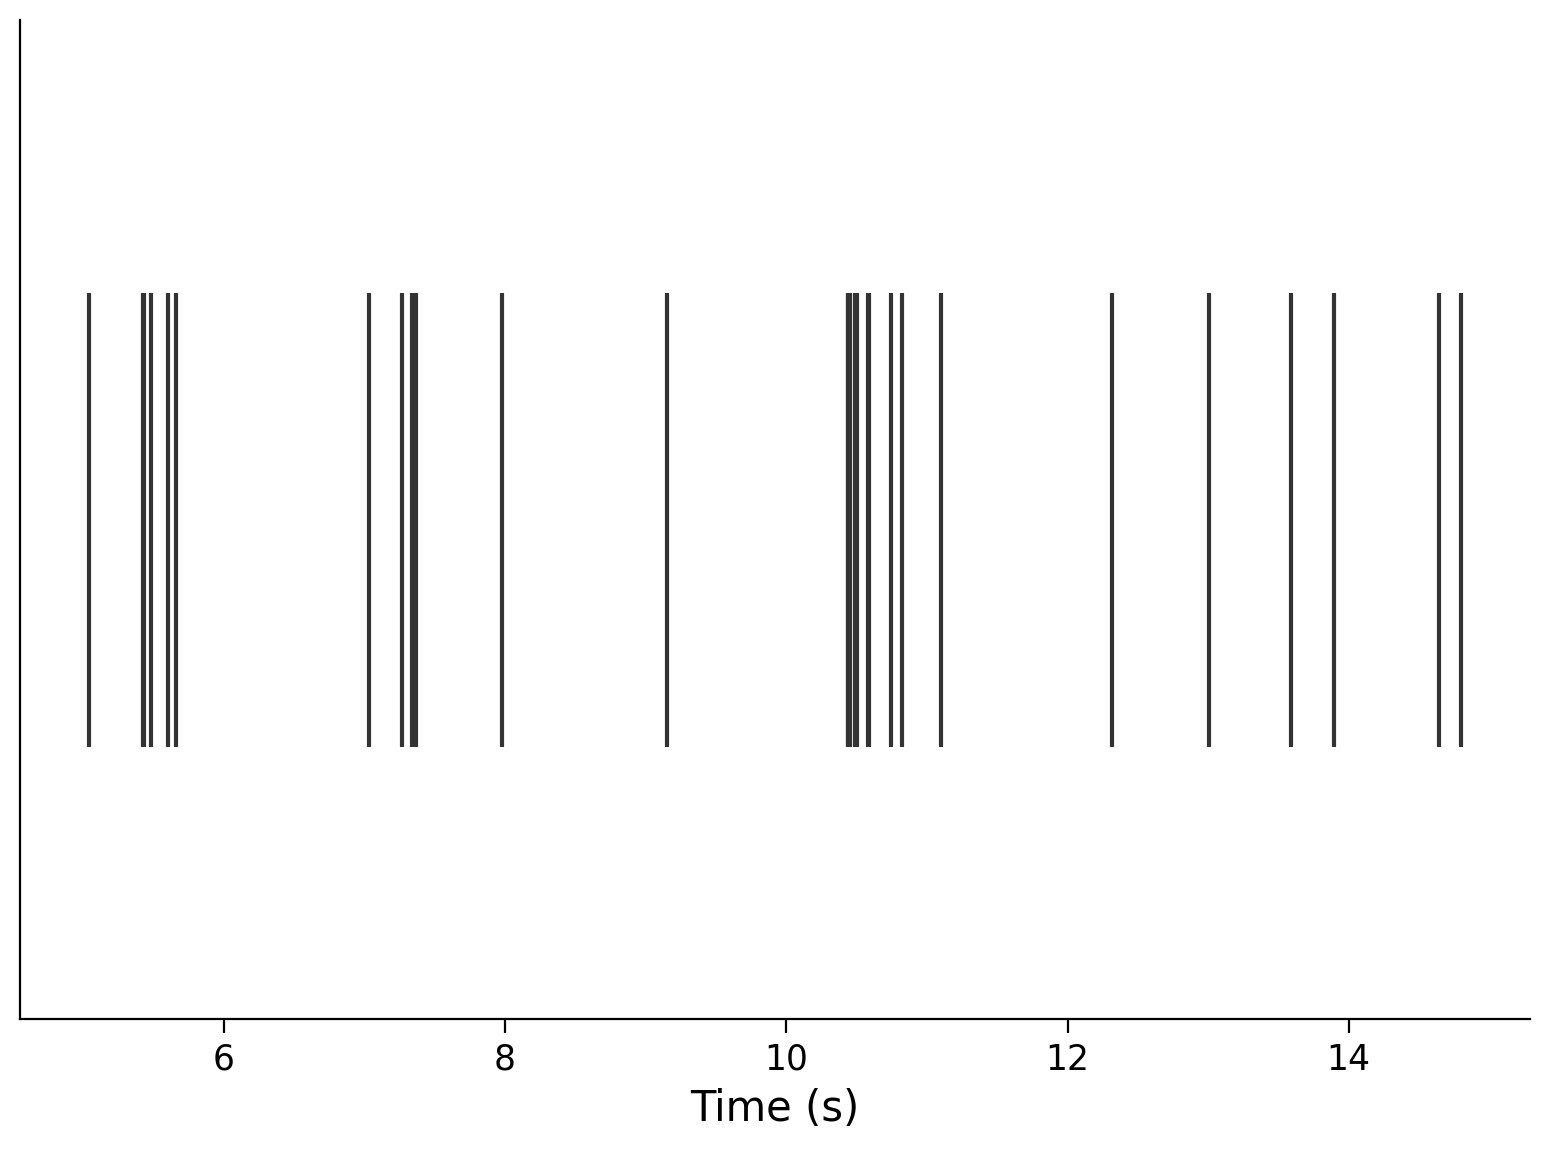

In [37]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

We can also plot multiple neurons. Here are three:

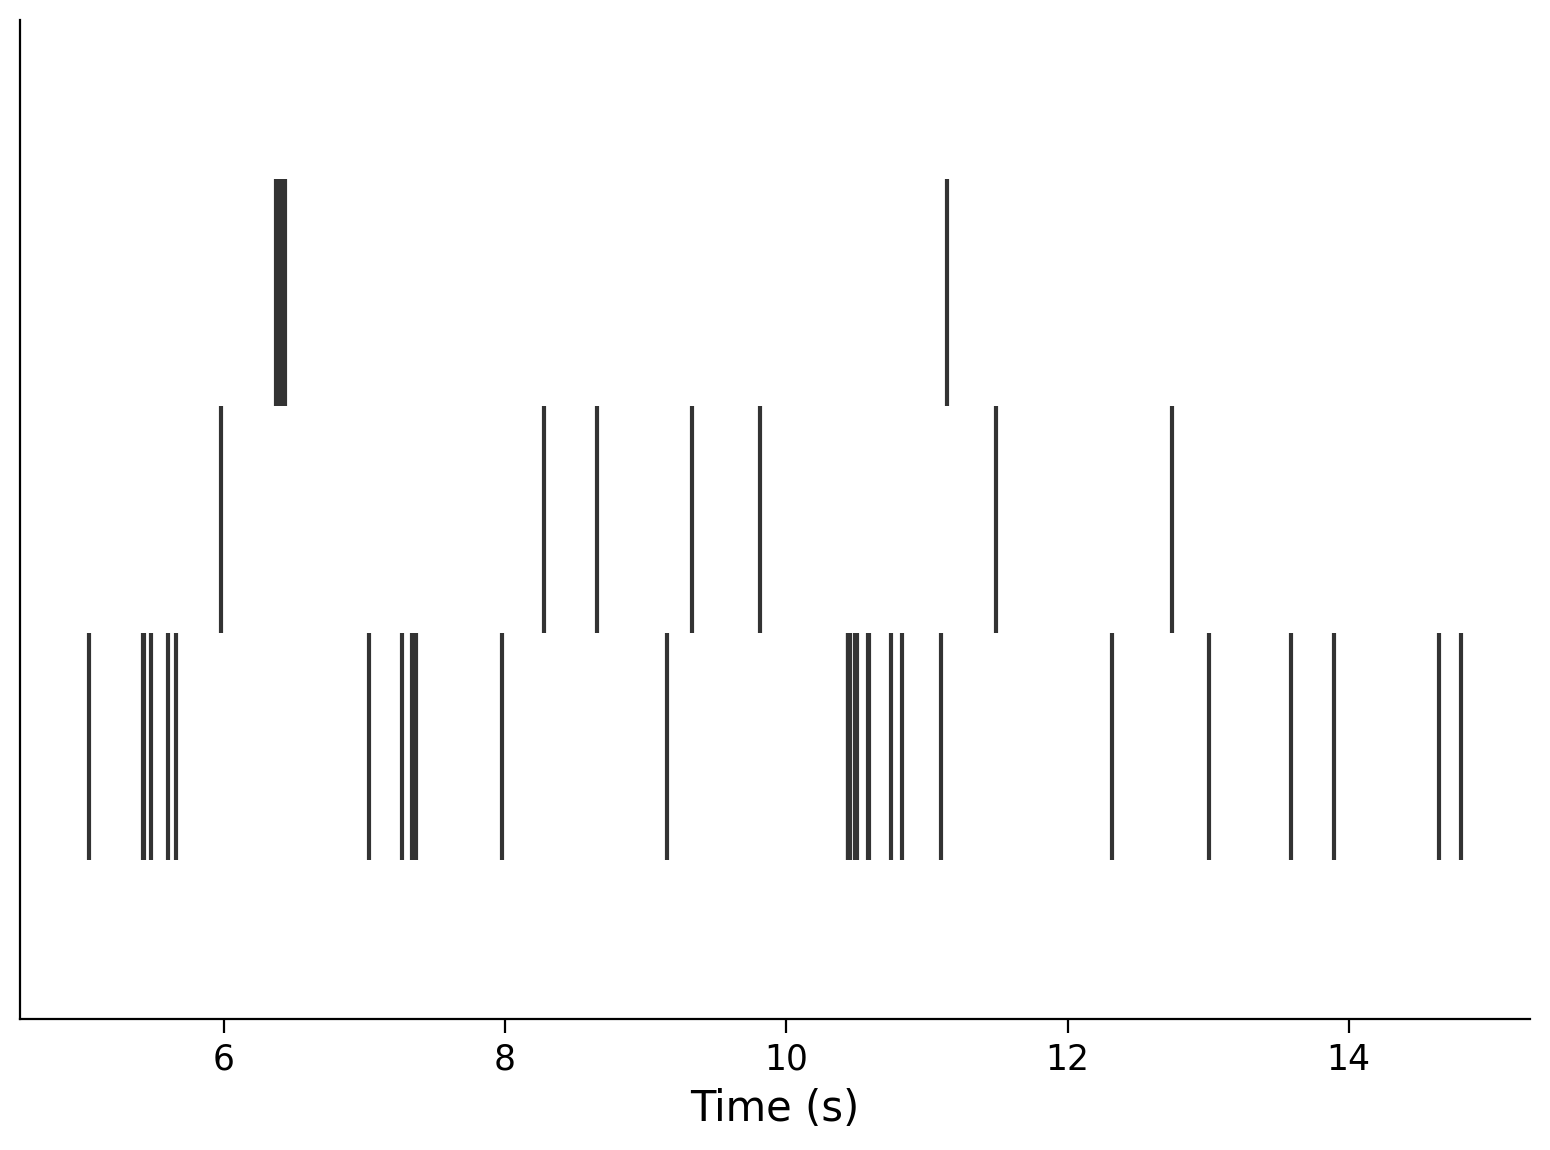

In [36]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

This makes a "raster" plot, where the spikes from each neuron appear in a different row.

Plotting a large number of neurons can give you a sense for the characteristics in the population. Let's show every 5th neuron that was recorded:

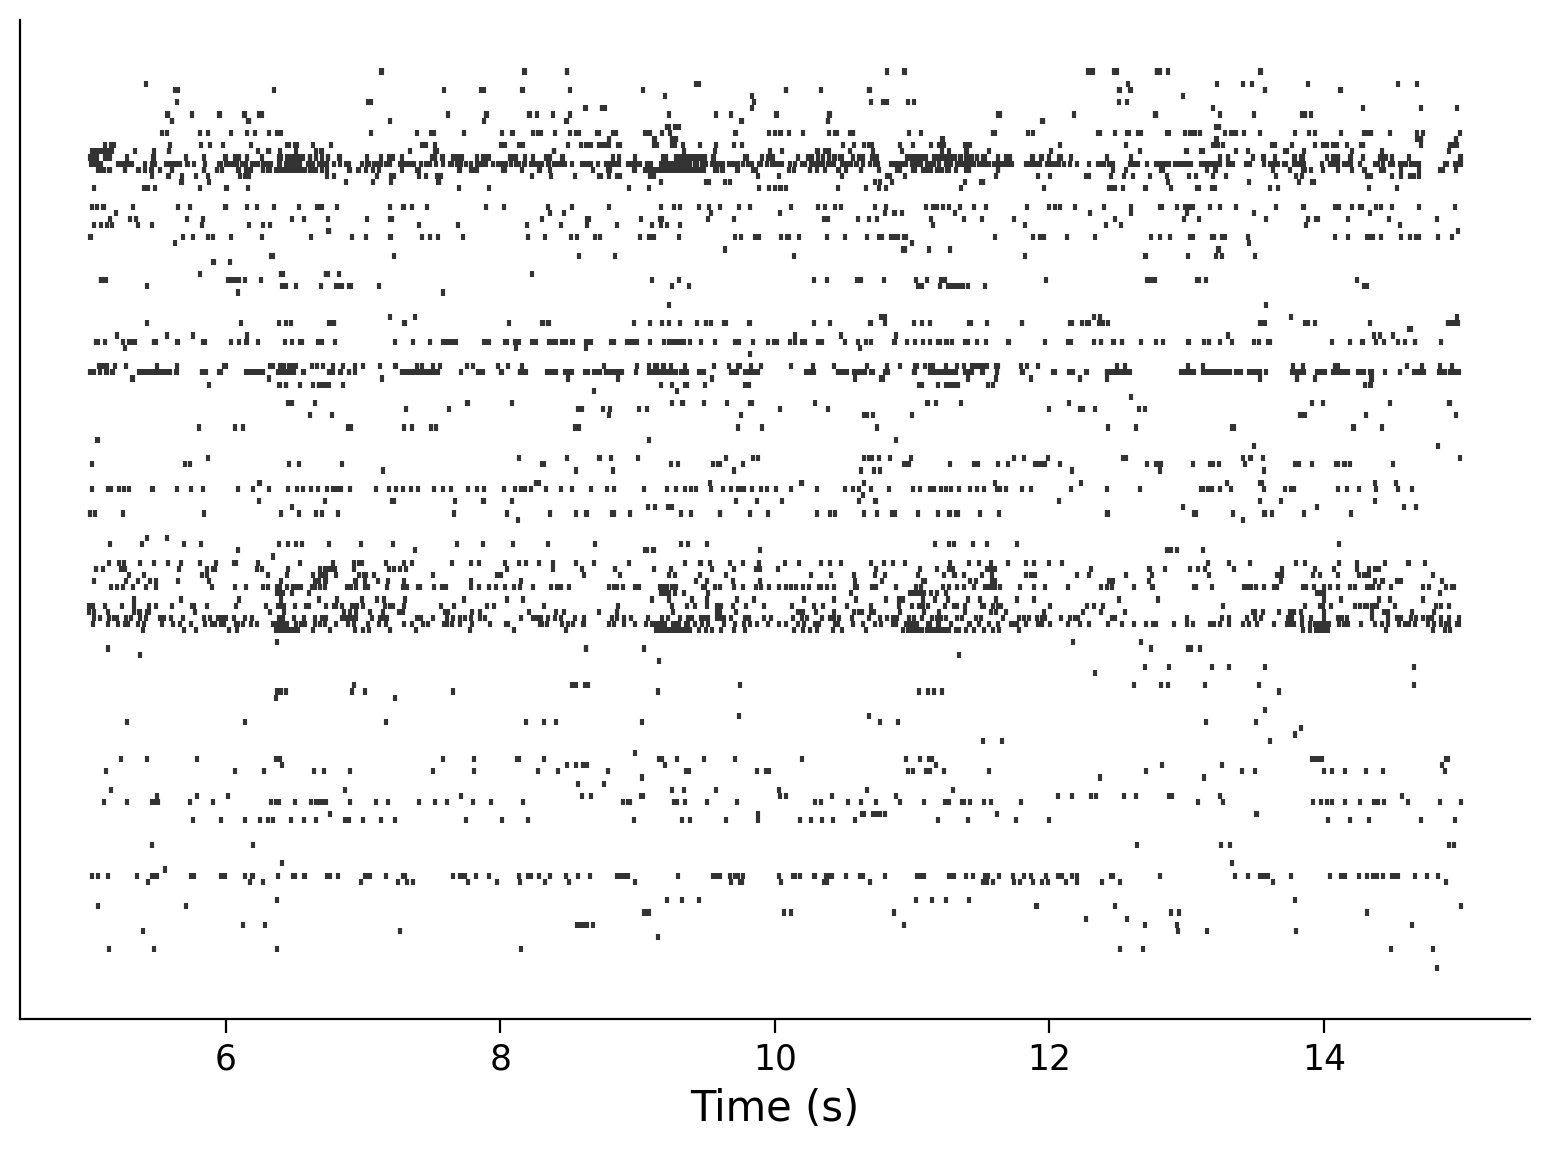

In [38]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

*Question*: How does the information in this plot relate to the histogram of total spike counts that you saw above?

---

# Section 3: Inter-spike intervals and their distributions

*Estimated timing to here from start of tutorial: 25 min*

Given the ordered arrays of spike times for each neuron in `spike_times`, which we've just visualized, what can we ask next?

Scientific questions are informed by existing models. So, what knowledge do we already have that can inform questions about this data?

We know that there are physical constraints on neuron spiking. Spiking costs energy, which the neuron's cellular machinery can only obtain at a finite rate. Therefore neurons should have a refractory period: they can only fire as quickly as their metabolic processes can support, and there is a minimum delay between consecutive spikes of the same neuron.

More generally, we can ask "how long does a neuron wait to spike again?" or "what is the longest a neuron will wait?" Can we transform spike times into something else, to address questions like these more directly?

We can consider the inter-spike times (or interspike intervals: ISIs). These are simply the time differences between consecutive spikes of the same neuron.

### Exercise 3: Plot the distribution of ISIs for a single neuron

*Exercise objective:* make a histogram, like we did for spike counts, to show the distribution of ISIs for one of the neurons in the dataset.

Do this in three steps:

1. Extract the spike times for one of the neurons
2. Compute the ISIs (the amount of time between spikes, or equivalently, the difference between adjacent spike times)
3. Plot a histogram with the array of individual ISIs

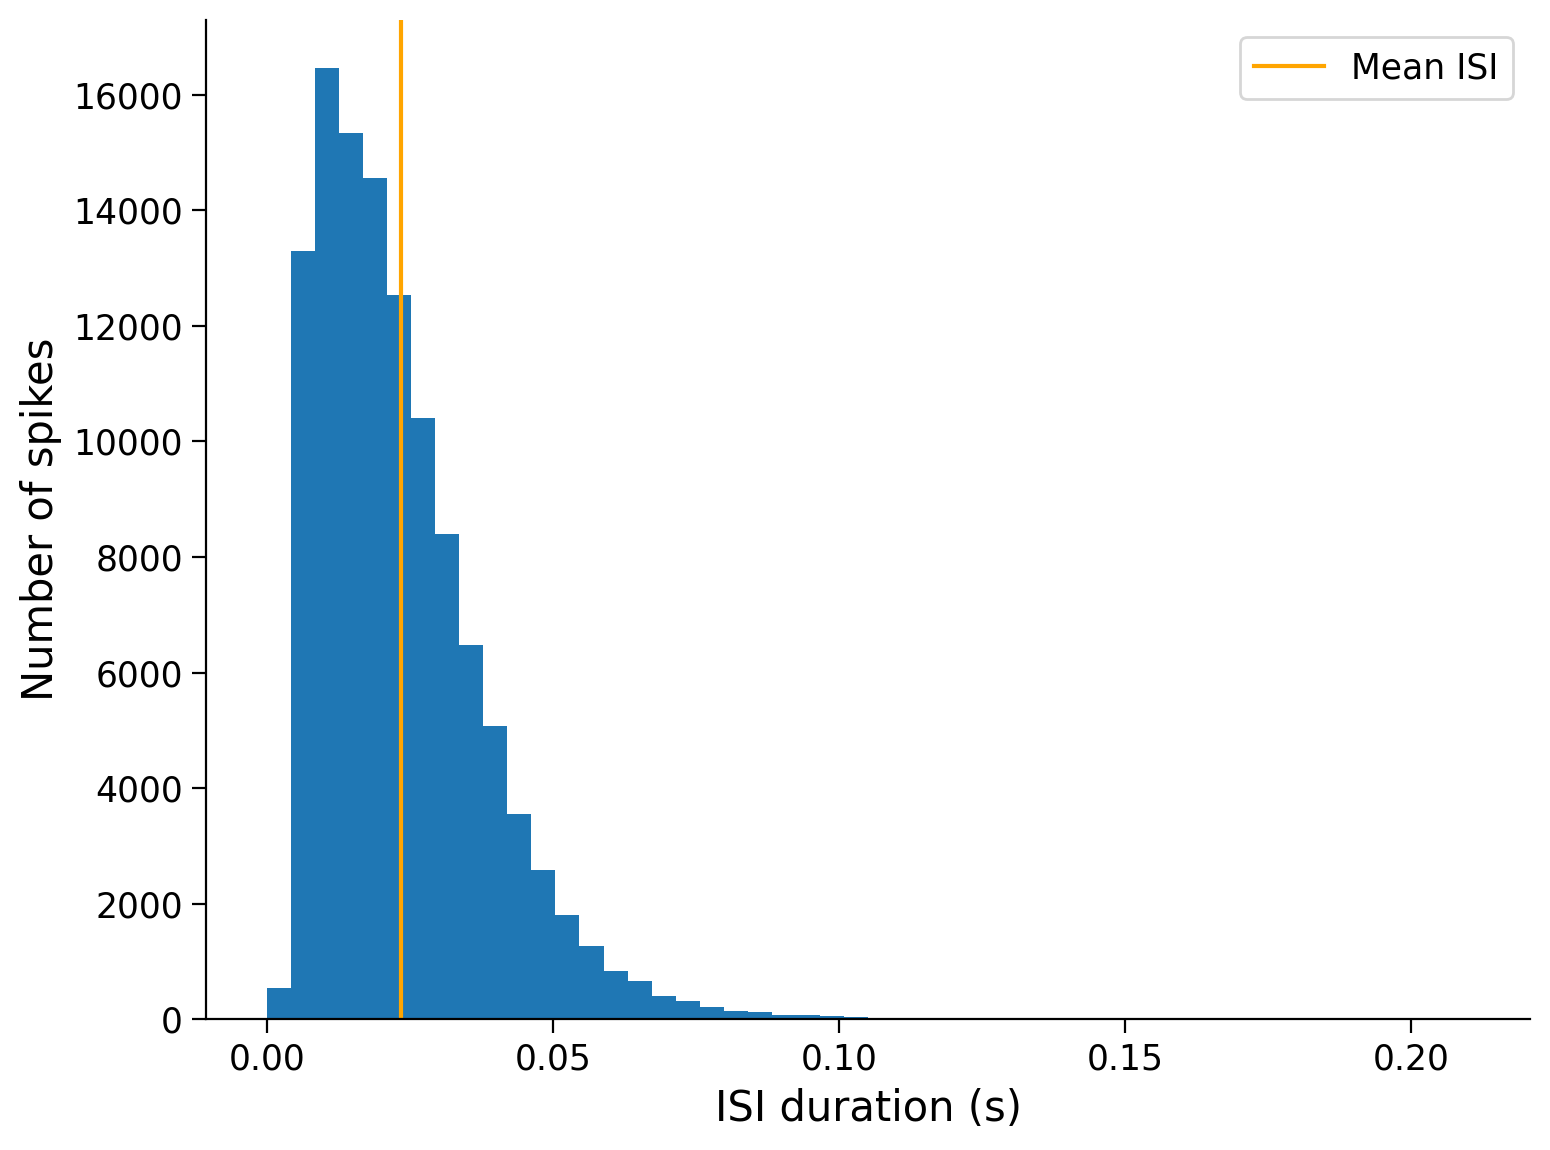

In [39]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  #############################################################################
  # Students: Fill in missing code (...) and comment or remove the next line
  #raise NotImplementedError("Exercise: compute single neuron ISIs")
  #############################################################################

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

In general, the shorter ISIs are predominant, with counts decreasing rapidly (and smoothly, more or less) with increasing ISI. However, counts also rapidly decrease to zero with _decreasing_ ISI below the maximum of the distribution (8-11 ms). The absence of these very low ISIs agrees with the refractory period hypothesis: the neuron cannot fire quickly enough to populate this region of the ISI distribution.

Check the distributions of some other neurons. To resolve various features of the distributions, you might need to play with the value of `bins` in the call to `plt.hist`. Using too few bins might smooth over interesting details, but if you use too many bins, the random variability will start to dominate.

You might also want to restrict the range to see the shape of the distribution when focusing on relatively short or long ISIs. *Hint:* `plt.hist` takes a `range` argument

---

# Section 4: What is the functional form of an ISI distribution?

*Estimated timing to here from start of tutorial: 35 min*

The ISI histograms seem to follow continuous, monotonically decreasing functions above their maxima. The function is clearly non-linear. Could it belong to a single family of functions?

To motivate the idea of using a mathematical function to explain physiological phenomena, let's define a few different function forms that we might expect the relationship to follow: exponential, inverse, and linear.

In [39]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

### Interactive Demo 4: ISI functions explorer

Here is an interactive demo where you can vary the parameters of these functions and see how well the resulting outputs correspond to the data. Adjust the parameters by moving the sliders and see how close you can get the lines to follow the falling curve of the histogram. This will give you a taste of what you're trying to do when you *fit a model* to data.

"Interactive demo" cells have hidden code that defines an interface where you can play with the parameters of some function using sliders. You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

- Which type of function (exponential/inverse/linear) can you make match the data best?


In [40]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

---
# Section 5: Reflecting on what models

*Estimated timing to here from start of tutorial: 40 min*

## Think! 5: Reflecting on what models

Please discuss the following questions for around 10 minutes with your group:
- Have you seen what models before?
- Have you ever done one?
- Why are what models useful?
- When are they possible? Does your field have what models?
- What do we learn from constructing them?

---
# Summary

*Estimated timing of tutorial: 50 minutes*

In this tutorial, we loaded some neural data and poked at it to understand how the dataset is organized. Then we made some basic plots to visualize (1) the average level of activity across the population and (2) the distribution of ISIs for an individual neuron. In the very last bit, we started to think about using mathematical formalisms to understand or explain some physiological phenomenon. All of this only allowed us to understand "What" the data looks like.

This is the first step towards developing models that can tell us something about the brain. That's what we'll focus on in the next two tutorials.